# Machine Learning Demonstration

## NASA Frontier Development Lab - Disaster Prevention, Progress and Response (Floods)

Floods are the most destructive and dangerous natural disasters worldwide. All regions can be affected by flooding events and, with the increased variability in weather patterns due to global warming, this is likely to become even more prelevant. The speed at which flooding events can occur, and difficulties in predicting their occurrance, create huge logistic problems for both governmental and non-governmental agencies. Over the past 10 years, floods have caused on average 95 deaths a year in the US alone, making them the deadliest weather related phenomenon. Worldwide, floods cost in excess of 40 Billion dollars per year, impacting property, agriculture and the health of individuals.

During the duration of the project, we collaborated with United States Geological Survey (USGS), a scientific agency within the US Department of the Interior. The objective of the organization is to study the landscape of the US and provide information about its natural resources and the natural hazards that affect them. Currently, hydrologists use physical models to help predict floods. These models require predictions to be carefully calibrated for each stream or watershed and careful consideration must be taken for dams, levees etc. Producing these models is extremely costly due to resource requirements. This limits the areas within the US that can avail of such systems to better prepare for flood events.


To predict the flood susceptibility of a stream area, the project was separated into two distinct problems.

Monthly Model

Predicting, per month, if a stream height will reach a flood threshold or not. These flood thresholds were set by the National Oceanic and Atmospheric Administration (NOAA) and were location specific. Knowing which areas are susceptible to flooding, allow locations to better prepare for a flood event.

Time to Peak Model

Predicting the time to peak of a flood event. When a major rain event occurs, knowing how long it will take for a river to reach its peak height is necessary in order to inform potentially affected individuals if and when they need to evacuate. This can help to reduce structural damage and loss of life during a disaster.



## The Data

This project focused on 6 states within the US, over a period of 10 years. Data was taken from ~800 gauge sites, between July 2009 and June 2019. Not all gauge sites had continuous historical data over the period, but all the available data for each site was used.

The 6 states were:

    -New Jersey
    -Nebraska
    -South Carolina
    -New York
    -South Dakota
    -Virginia
    
A primary reason for choosing these states, was that each exhibits similar climate and landscape. Focusing on similar geographies helped to ensure that the models produced were precise.

Other required datasets and providers:

**USGS**

This consists of the height of a stream as measured by gauges for over 11,000 sites in the US. The data is updated every 15 minutes, with some locations having historical data for over 50 years. 

**PRISM**

The PRISM Climate Group provides climate observations across the whole of the US. This dataset was used to extract daily precipitation readings from the site locations for each day during the requested 10 year period.

**National Land Cover Database (NLCD)**

The NLCD database was collected using Landsat. This provides information such as land-use classification (urban, agriculture, forest, etc.), how well the land allows water to pass through it (impervious surface information) and tree cover. This dataset has updated records every 5 years from 2006.

**National Hydrology Dataset Plus (NHDPlus)**

NHDPlus is a geo-spatial hydrologic framework dataset associated with USGS. The features used from this dataset were the catchment and drainage area characteristics at the stream site locations. 

**Flooded Locations And Simulated Hydrographs Project (FLASH)**

FLASH is a database containing information about flood events within the US. The information used from this dataset was the time taken for a river to reach its peak height after a major rain event.

**NOAA**

NOAA is a US governmental agency for monitoring and preserving the climate and environment. This dataset provided flood level thresholds for locations across the US. These thresholds consisted of four warning stages and the river height for a given location that causes them to reach these levels. The four warning stages were:

|Warning |Meaning                                                                                     |
|--------|-------                                                                                     |
|Action  |	Mitigation action needs to be taken in order to prepare for possible hydrological activity|
|Flood	 |The river height poses a threat to lives, property and businesses|
|Moderate| 	Some inundation of roads or buildings. A flood warning should be released|
|Major	 |Extensive inundation of roads and buildings. Considerable evacuations of areas may occur|


A more indepth discussion on these dataspurces can be found within the associated whitepaper.

An implementation describing how to download the stream gauge height data from USGS over the 10 year period can be found in the stream.q file

## Load Required Libraries

In [1]:
// Load the machine learning toolkit
\l ml/ml.q 
.ml.loadfile`:init.q

// Load flood data and associated code
\l ../floods.q
.fld.loadfile`:init.q

### Cleaning up the Dataset 

As the datasets came from a variety of different sources, cleaning up the data to make them consistent was an important initial task before any feature engineering could be done.

The id number of each stream site consisted of over 8 digits. Any containing less digits was front loaded with 0's. 

Any nulls or infinity values from the dataset were also deleted.

In [2]:
del:{![x;enlist (=;y;z);0b;`symbol$()]}
conv7_fn:{`$$[7=count x;"0",;]x}
precip:update conv7_fn each string each site_no from del[precipall;`ppt;0n]
maxht :update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

The index for each location within the NOAA threshold dataset was also added. This indexing was added for joining tables based on nearest neighbours, which will be seen in a later section of the notebook.

In [3]:
warning:update nn:i from warnings

The PRISM dataset had a location site id limit of 12 digits, any digits over this limit were excluded. To not lose datapoints, the remaining digits were manually added back in. This was achieved by extracting all ids from the stream gauge dataset. The first 12 digits of each id that exceeded the cut off limit was used to match site ids from the PRISM dataset to its correct form.

Two of the unique ids had the same initial 12 digits, meaning their latitude and longitude had to be taken into account in order to correctly match the ids. This was done below in `matchnames` by manually searching what id this occured at, and extracting the indices in the table, grouping them by their unique latitude and longitude values, that corresponded to this PRISM id.

In [4]:
rms  :asc ds where 12<count each ds:string exec distinct site_no from gauges 
names:0!select i by site_no from precip where site_no in `$12#'rms

// What's so special about the 20'th x of the names table?
//when some digits are cut off the prism data,two of the id numbers become equal.
//i.e before getting cut off the id's could be 111123,111134,after exlclusion of last 2 digits are then 1111
//I had to hand pick where this occured why is why in lst2, ind 20 is excluded because this is where it occurs,
//in lst1, 21 and 22 are exclued because this is what the actual ids should be
//matchnames then gets the index that these occur at because they have to be matched off their unique lat&long
matchnames:0!select i by lat,long from precip where i in names[`x][20]

lst1:til[26]except 21 22
lst2:til[25]except 20

// i1 if ascending is exactly equivalent to `$asc rms[til 26] why is this ordering important
// needed to be in that order to correctly match indices in the table with their correct id
i1:`$rms[lst1],rms[21 22]
// i2 similar thing why was there a need to deal with the 20th x differently and add on?
i2:(names[`x]lst2),matchnames`x

precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

## Feature Engineering

Given the data available, it was possible to split the information into three datasets

1. Ungauged basin: Information available at sites that do not contain stream gauge or future forecasting information. Data was limited to land use, past rainfall and upstream information.


2. Gauged basin: All information contained within the ungauged basin dataset, as well as stream gauge information. This included previous river heights and lagged/aggregated flooding information.


3. Perfect Forecasts: All information contained within the gauged basin dataset, as well as precipitation information around the time of the event.

Seasonal Information plays an important role when predicting if an area will flood and how long it will take. This seasonality was captured by using sine and cosine functions to transform the month of the year that the event occured. The latitude and longitude of the stream sites represented in their x,y and z coordinates were also included.

Because the NLCD dataset is updated every 5 years starting from 2006, an additional `nlcdyear` column was added to the dataset which was used to aid joining between the precipitation and NLCD dataset. This column indicated which NLCD dataset was to be joined to each row by creating an upper year bound. For example, an event that occured before 2011 was joined to the 2006 NLCD dataset, an event that occured before 2016 was joined to the 2011 dataset.

In [5]:
pi:acos -1
// why is this naming convention used?
// x,y,z is the x, y z coordinates in relation to lat and long
precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip
precip:`date xasc update month:`mm$date from precip
// why are sine and cosine months important? any reason for the 1->0 ... 12->11 vs. using 1->12 as months?
//Followed a formula online, the neg[1] is just a more convenient convention used when looking at cyclical values
//I found differnt formulas that used division by 11 or 12. Both can be changed if looks nicer and less complicated
precip:update cos_t:cos 2*pi*(month-1)%11,sin_t:sin 2*pi*(month-1)%11 from precip
// what is the reason for this standarization decision?
//This is used later on for joining the tables with the appropriate basin characteristic table.
//this is because the tables are updated every 5 years so this is how we decided what NLCD tables to join with the
//precip data based on date
nlcdyear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]
precip:update year:nlcdyear from precip

To obtain these features, the feat function was used to extract previous information along with windowed features. This function takes the following parameters as input:


feat:

`x`    table that's being updated

`y`    how many values to calculate (integer list)

`z`    column to apply the function to (symbol)
        
`col`  new column name (symbol)
        
`d`    dictionary of where, groupby and what type of functional statement is used
        
`fnc`  function that is applied to the grouped columns


In [6]:
colname:{enlist`$string[y],"_",string[x],"_",string[z]}
max_mavg:{(max;(mavg;y;x))}
prv:{(xprev;y;x)}

// concerned that these functions do too much
//can be seperated into 2 separate functions,extracting window features and previous values if easier to understand?
//showed in the cell below, looks similar but is easier to identify what features is actually being extracted?

func:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}
feat:{[x;y;z;col;d;fnc] d[`w][x;d`wh;d`gr;$[1<count[z];raze;]func[y;col;;fnc]each z]}

In [ ]:
//
//do not run
/alternative extracting features function
/func:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}
/feat:{[x;y;z;wh;gr;col;w;f]w[x;wh;gr;$[1<count[z];raze;]func[y;col;;f]each z]}

/window_feat:{[x;y;z;wh;gr;col;w]feat[x;y;z;wh;gr;col;w;m_avg]}
/prev_col:{[x;y;z;gr;col]feat[x;y;z;();gr;col;!;prv]}

To obtain the upstream values the feat function was used. The id number of each stream site consisted of over 8 digits. The first two digits were the grouping number of the river basin catchment. While the remaining digits were in ascending order based on the location of the gauge along the stream.

In [7]:
catch_site:((';#);2;($:;`site_no))
site_date:`site_no`date!(catch_site;`date)
dict:`w`wh`gr!(!;();site_date)
upstr_ppt:feat[precip;1;`ppt;`upstr;dict;prv]
upstr_height:feat[maxht;1;`height;`upstr;dict;prv]

The feat function was also used to obtain previous values of both rainfall and stream gauge height readings before each date, for both the current location and sites upstream.

In [8]:
dict[`gr]:site:(enlist `site_no)!enlist `site_no
prev_rain:feat[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;`prev;sited:dict;prv]
all_height:feat[upstr_height;enlist 1_til 10;`height`upstr_height_1;`prev;dict;prv]

The above features were applicable to both aspects of this project. However, additional features that were problem specific were also added.

### Monthly Models

When forecasts are provided for each model, knowing how the average rainfall will change over differnet window sizes for each month is a feature that can be added to the dataset.

In [9]:
dict[`gr]:(`date`site_no)!(($;enlist`month;`date);`site_no)
all_rain:feat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;`window;dict;max_mavg]

By taking the first day of each month at a site, it was possible to obtain the maximum moving averages of precipitation for different window sizes for a given month, along with the precipitation and height values for the last few days of the month prior.

In [10]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data:update date:"m"$date from select from all_rain where 1=`dd$date

This stream height and rain data were joined based on site number and month to create `monthly_data`

In [11]:
monthly_data:height_data ij`site_no`date xkey rain_data

### Time to Peak Model

For the time to peak dataset the daily rain and height data is joined to the FLASH dataset based on the site number and date along with the stream_char dataset.

In [12]:
peak_data:(peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height

The hours before a flood event can provide important information on how quickly the stream gauge height is moving. This is incredibly useful to a model predicting how long it will take for the stream to reach its peak height. The information extracted at a given stream location, comprised of the maximum moving averages over different bucket sizes for the two days before the event. This was found using stream height data from USGS, which was updated at 15 minute intervals.

To make the times from the stream height dataset consistent with the FLASH dataset, the times were converted to be time zone agnostic.

These zones consist of 

    -EDT: Eastern Daylight Time
    -CDT: Central Daylight Time
    -EST: Eastern Standard Time

In [13]:
time_zone:raze{dd:x[1];si:x[0];
          select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each 
          value each 0!select date by distinct site_no from peak_data;
peak_data:peak_data ij`site_no xkey time_zone
change_zone:{$[y=`EDT;x-04:00;y=`CDT;x-05:00;x-06:00]}

This transformation was applied to the start, end and peak-time of the event. The date also needed to be updated in some cases to coincide with the time change.

In [14]:
peak_data[`start_time`end_time`peak_time]:change_zone''[;peak_data`unk]each peak_data`start_time`end_time`peak_time
peak_data[`date]:`date$peak_data`start_time

The previous hours before the flood event occurs can show information on how quickly the stream gauge height is moving which can be useful to the model in predicting how long it will take to peak. To do this the 2 days before the event are extracted, and moving averages of different sizes are applied to the stream height dataset

In [15]:
range:{(within;x;(,;(+;(-:;2);y);y))}
wh:{(range[`date;x[1]];range[`datetime;x[2]];(=;x[0];($;enlist`;`site_no)))}
dict:{`w`wh`gr!(?;wh x;0b)}
wind_ht_prev:{feat[str;enlist 2 4 12 48;`height;`wind_prev;dict x;max_mavg]}each 
             flip peak_data[`site_no`date`start_time]

This was joined back to the dataset with any nulls or infinity values excluded

In [16]:
peak_data:peak_data,'raze wind_ht_prev
peak_data:del[peak_data;`wind_prev_height_2;neg[0w]]

For models that use rain forecasts, information about the projected rainfall in the days following the event, were also extracted and joined onto the dataset

In [17]:
wh:{((within;`date;(,;y[1];(+;y[1];x)));(=;y[0];`site_no))}
dict:{`w`wh`gr!(?;wh[x;y];0b)}
rain_pred:{feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;`fut_window;dict[x;y];max_mavg]}[3]
          each flip peak_data[`site_no`date]
peak_data:peak_data,'raze rain_pred

## Target Data

### Monthly Models

The target data used in this case was the Flood level warning, extracted from the NOAA dataset.

The latitude and longitude of these provided thresholds did not exactly match the stream gauge locations. As such, the latitudes and longitudes of both the stream locations and NOAA threshold readings were joined using a k-dimensional tree (kd-tree) nearest neighbours algorithm. 

In [18]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]
tabw:kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:kd.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

A table was created indicating the nearest neighbour threshold location for each stream site. The index of the nearest neighbour was added as a column so that the `maxht` table could be joined to the NOAA threshold data based on it's nearest location.

In [19]:
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])
floodlvl:(maxht ij joins)lj`nn xkey warning
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

This dataset was then joined onto the stream gauge data, adding columns counting the number of times a given stream gauge reached each warning level per month.


In [20]:
show threshold:0!select first Action,first Flood,first Moderate,first Major,no_Action:count where height>Action
              ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
               height>Major by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1


For the sake of this project, we only wanted to focus on the "Flood" stage. This level was chosen in an attempt to achieve a more balanced dataset while still predicting a meaningful target. Choosing either of the more severe levels would result in a very low number of targets making it more difficult to discern events of interest. Our target data was a binary label denoting whether the flood warning level was reached in a given month. Any site that claimed to flood more than 28 days per month were omitted from the dataset as we only wanted to focus on events that occured infrequently and were more difficult to predict.

In [21]:
threshold:select from threshold where no_Flood<28
threshold[`target]:threshold[`no_Flood]>0

### Time to Peak Model

The FLASH dataset was then used for the time to peak model, which highlights how long it will take a stream gauge location to reach its peak height after the rain event.

Only dates within the 10 year period and site numbers within the 6 states mentioned were included. The target data was calculated by subtracting the start-time (denoted by the start of a major rainfall event at the location) from the time that the peak height was found to occur.

In [22]:
peak_data[`delta_peak]:(peak_data[`peak_time]-peak_data[`start_time])*24

This was then converted into a binary classification problem by setting a threshold for a 'flash flood' at 3.5 hours after the major rainfall event. Any time above this was set to 0b and less than this time was 1b. This threshold was chosen after discussions with hydrologists, who found this to be a reasonable split in the dataset.

In [23]:
peak_data[`target]:peak_data[`delta_peak]<3.5

## Joining the characteristics tables 

The basin characteristics and NLCD landcover dataset were joined based by site_no (stream site id) to create the `stream_char` dataset. This was then joined to the `monthly_data`and `peak_data` tables based on site number and year. The flood threshold target data created above, was also joined to the monthly dataset by site_no and date.

In [24]:
stream_char:nlcd ij`site_no xkey basin
all_peak_data:peak_data ij`site_no`year xkey stream_char
all_monthly_data:(monthly_data ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

### Lagged features

For the monthly model, lagged features were then added to this dataset, which included information such as whether a flood occurred in the month or year prior.

In [25]:
all_monthly_data:feat[all_monthly_data;enlist 1 12;`target;`lagged;sited;prv]
tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data
all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each?[tgts;();();`no_Flood]

## Train Test Split

Any nulls were deleted from the dataset

In [26]:
del_null:{where not any each null x}
cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

The appropriate feature columns for the monthly and time to peak models were extracted for each of the three separate datasets mentioned earlier in the notebook:

1. Ungauged
2. Gauged
3. Perfect Forecasts


The columns that need to be included for each of the separate datasets are contained within the `columns_to_include.q` under the following headings:

1. ungauged_cols
2. gauged_cols
3. perfect_cols

In [27]:
fnd_col:{x where x in y}
ungauged_colsM:         fnd_col[ungauged_cols;cols cleaned_monthly]
gauged_colsM:           fnd_col[gauged_cols;cols cleaned_monthly]
perfect_forecast_colsM: fnd_col[perfect_forecast_cols;cols cleaned_monthly]

ungauged_colsP:         fnd_col[ungauged_cols;cols cleaned_peak]
gauged_colsP:           fnd_col[gauged_cols;cols cleaned_peak]
perfect_forecast_colsP: fnd_col[perfect_forecast_cols;cols cleaned_peak]

A dictionary was created, containing the different feature columns required to make up the above datasets for each of the monthly (M) and time to peak (P) models.

In [28]:
ungauge: `M`P!(ungauged_colsM;ungauged_colsP)
gauge:   `M`P!(ungauge[`M],gauged_colsM;ungauge[`P],gauged_colsP)
forecast:`M`P!(gauge[`M],perfect_forecast_colsM;gauge[`P],perfect_forecast_colsP)

These dictionaries were then used to extract the appropriate columns from each table, to make them suitable inputs to machine learning models. This was achieved by using the `split_dict` function which takes a table as input, aswell as `M` or `P`, indicating which model was being used. The function returns a dictionary containing the matrix for each of the ungauged, gauged and perfect forecast datasets.

In [29]:
split_dict:{(!). flip(
  (`ungauged;flip x[ungauge[y]]);
  (`gauged;flip x[gauge[y]]);
  (`forecast;flip x[forecast[y]]))}

### Monthly Model

When splitting the data for this model, it was deemed important that no time leakage occurred between the training and test sets (e.g. the training set contained information from 2009 to 2017, while the test set contained the remaining years). This ensured that the model was being tested in a way that was similar to a real-world deployment. A split was chosen so that 20 percent of the data for each site was in the test set. The `split_dict` function was used to create the `XtrainM` and `XtestM` datasets

In [30]:
cutoff:update cutoff:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly
XtrainMi:select from cutoff where date<cutoff
ytrainM:exec target from cutoff where date<cutoff
XtestMi:select from cutoff where date>=cutoff
ytestM:exec target from cutoff where date>=cutoff

XtrainM:split_dict[XtrainMi;`M]
XtestM:split_dict[XtestMi;`M]

### Time to Peak Model

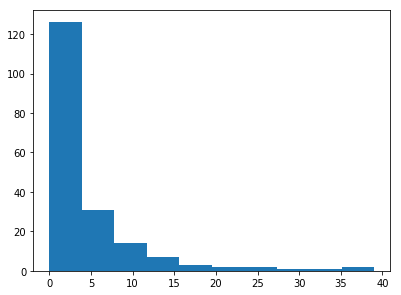

In [31]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:show][];

The time to peak data was separated so that sites did not appear in both the train and test dataset. This was done to ensure that the models being produced could be generalized to new locations. The target data was binned into a histogram as above and the train test split completed such that the distribution of targets in the training and testing sets were stratified.

In [32]:
train_test_split:.p.import[`sklearn.model_selection]`:train_test_split
bins:0 5 15 25.0
y_binned:bins bin`float$sites`target
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

An additional column was added indicating whether each row belonged to the training or testing set.

In [33]:
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in`$tts[1]

The `split_dict` function was again used to create the `XtrainP` and `XtestP` datasets

In [34]:
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
XtestP:split_dict[XtestPi;`P]

## Build Models

For both problems a variety of models were tested, but for the sake of this notebook, only models and results from an eXtreme Gradient Boost (XGBoost) and random forest classifier are presented below. These models were chosen due to their ability to deal with complex, imbalanced datasets. A more indepth discussion of these models can also be found in the associated whitepaper.


The dictionary of models consisted of XGBoost and a random forest model, with varying hyper-parameters for each model taken as input to the model in the form of a dictionary. This dictionary contains hyper-parameters such as the number of estimators, class-weight, max_depth and learning rate associated with each model.

In [35]:
build_model:{[Xtrain;ytrain;dict]
 rf_clf:      RandomForestClassifier[`n_estimators pykw dict`rf_n;`random_state pykw 0;
            `class_weight pykw(0 1)!(1;dict`rf_wgt)][`:fit][Xtrain; ytrain];
 xgboost_clf: xgboost_clf: XGBClassifier[`n_estimators pykw dict`xgb_n;`learning_rate pykw 
              dict`xgb_lr;`random_state pykw 0;`scale_pos_weight pykw dict`xgb_wgt;
              `max_depth pykw dict`xgb_maxd][`:fit][np[`:array]Xtrain; ytrain];
 `random_forest`XGB!(rf_clf;xgboost_clf)}

To visualize the results, a precision-recall curve was used, illustrating the trade off between the positive predictive value and the true positive rate over a variety of probability thresholds.

A function named pr_curve was created to output the desired results from the models. This function outputs the accuracy of prediction, the meanclass accuracy, a classification report highlighting the precision and recall per class, along with a precision-recall curve. This function also returned the prediction at each location in time for the models used, this can be seen later in this paper to create a map of flooding locations.

The inputs to the pr_curve function are:

`Xtest`      matrix of feature values

`ytest`      list of targets

`dict`       dictionary of models that are being used

## Results

The results below were separated based on the three datasets.



### Ungauged Prediction 

### Monthly Model


Accuracy for random_forest: 0.9392063


Meanclass accuracy for random_forest: 0.8513272


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9427977 0.9949254 0.9681604 13203  
1        | 0.7598566 0.210109  0.3291925 1009   
avg/total| 0.8513272 0.6025172 0.6486765 14212  

Accuracy for XGB: 0.9207008


Meanclass accuracy for XGB: 0.6914636


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9520138 0.9631902 0.9575694 13203  
1        | 0.4309133 0.3647175 0.3950617 1009   
avg/total| 0.6914636 0.6639539 0.6763155 14212  


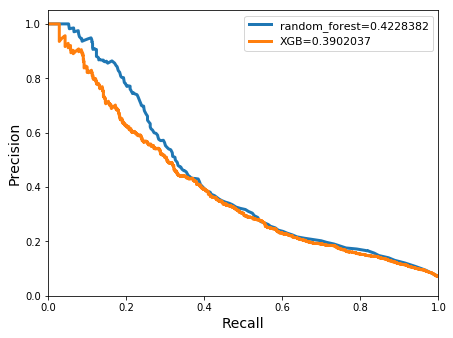

In [36]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)
pltU1:pr_curve[XtestM`ungauged;ytestM;build_model[XtrainM`ungauged;ytrainM;dict]]

### Time to Peak Model


Accuracy for random_forest: 0.7416974


Meanclass accuracy for random_forest: 0.7308405


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7452632 0.9490617 0.8349057 373    
1        | 0.7164179 0.2840237 0.4067797 169    
avg/total| 0.7308405 0.6165427 0.6208427 542    

Accuracy for XGB: 0.7730627


Meanclass accuracy for XGB: 0.7376155


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8109453 0.8739946 0.8412903 373    
1        | 0.6642857 0.5502959 0.6019417 169    
avg/total| 0.7376155 0.7121452 0.721616  542    


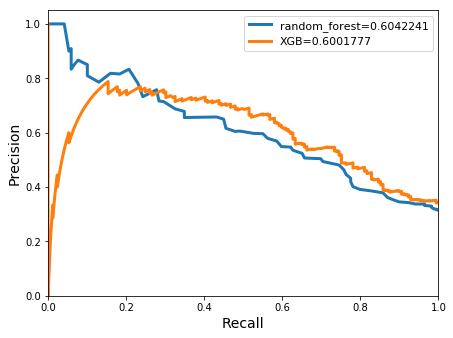

In [37]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;.01;1.5;3)
pltU2:pr_curve[XtestP`ungauged;ytestP;build_model[XtrainP`ungauged;ytrainP;dict]]

The monthly model obtained the highest accuracy scores using random forests, while the time to peak model performed best for XGBoost. In both cases, random forests achieved high precision scores and low recall results. Meanwhile, XGBoost gave a slightly more balanced precision/recall result.



## Gauged Prediction

### Monthly Model


Accuracy for random_forest: 0.943217


Meanclass accuracy for random_forest: 0.9163495


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9442374 0.9978035 0.9702817 13203  
1        | 0.8884615 0.2289395 0.3640662 1009   
avg/total| 0.9163495 0.6133715 0.667174  14212  

Accuracy for XGB: 0.93604


Meanclass accuracy for XGB: 0.7633167


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9547943 0.9774294 0.9659793 13203  
1        | 0.5718391 0.39445   0.4668622 1009   
avg/total| 0.7633167 0.6859397 0.7164207 14212  


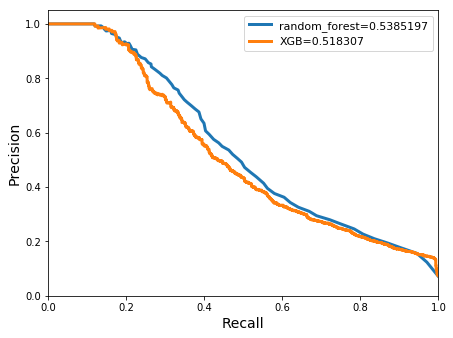

In [38]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;16;8;100;0.2;16;9)
pltG1:pr_curve[XtestM`gauged;ytestM;build_model[XtrainM`gauged;ytrainM;dict]]

### Time to Peak Model


Accuracy for random_forest: 0.7232472


Meanclass accuracy for random_forest: 0.6982818


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7298969 0.9490617 0.8251748 373    
1        | 0.6666667 0.2248521 0.3362832 169    
avg/total| 0.6982818 0.5869569 0.580729  542    

Accuracy for XGB: 0.7638376


Meanclass accuracy for XGB: 0.7325731


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7868852 0.9008043 0.84      373    
1        | 0.6782609 0.4615385 0.5492958 169    
avg/total| 0.7325731 0.6811714 0.6946479 542    


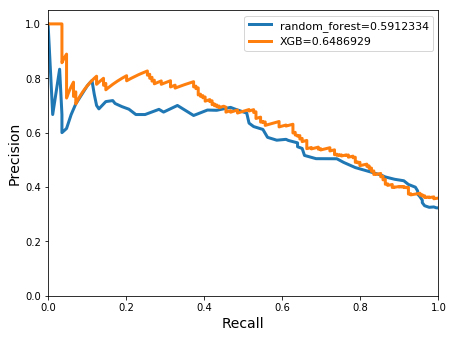

In [39]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;360;0.01;1.5;3)
pltG2:pr_curve[XtestP`gauged;ytestP;build_model[XtrainP`gauged;ytrainP;dict]]

Accuracy for the monthly model improved when compared with the previous predictions, whereas a decrease was observed for the time to peak model.

## Perfect Forecast

### Monthly Model


Accuracy for random_forest: 0.9458204


Meanclass accuracy for random_forest: 0.9194042


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9470051 0.9975006 0.9715972 13203  
1        | 0.8918033 0.2695738 0.414003  1009   
avg/total| 0.9194042 0.6335372 0.6928001 14212  

Accuracy for XGB: 0.9467352


Meanclass accuracy for XGB: 0.8004197


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9695895 0.9731879 0.9713854 13203  
1        | 0.63125   0.6005946 0.6155409 1009   
avg/total| 0.8004197 0.7868913 0.7934631 14212  


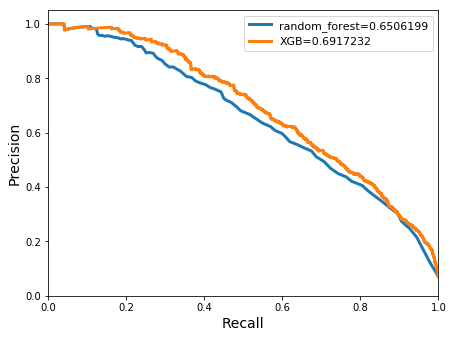

In [40]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)
pltP1:pr_curve[XtestM`forecast;ytestM;build_model[XtrainM`forecast;ytrainM;dict]]

### Time to Peak Model


Accuracy for random_forest: 0.7564576


Meanclass accuracy for random_forest: 0.7768992


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7505198 0.9678284 0.8454333 373    
1        | 0.8032787 0.2899408 0.426087  169    
avg/total| 0.7768992 0.6288846 0.6357601 542    

Accuracy for XGB: 0.7656827


Meanclass accuracy for XGB: 0.7266119


class    | precision recall   f1_score  support
---------| ------------------------------------
0        | 0.8203125 0.844504 0.8322325 373    
1        | 0.6329114 0.591716 0.6116208 169    
avg/total| 0.7266119 0.71811  0.7219266 542    


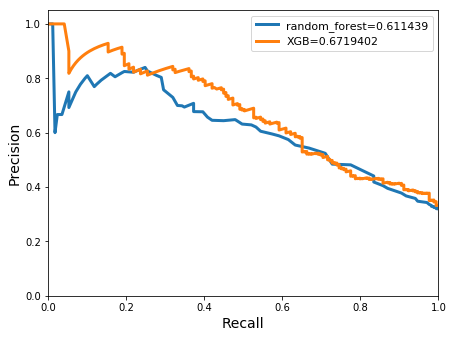

In [41]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)
pltP2:pr_curve[XtestP`forecast;ytestP;build_model[XtrainP`forecast;ytrainP;dict]]

In the above case, the XGBoost classifier achieved the hightest accuracy score in both models. Once again, XGBoost also gave a more balanced precision/recall score for both models.



### Feature Significance

There is also a lot to be learned from determining which features contribute to predicting the target for a model. To do this, the function ml.fresh.significantfeatures was applied to the data, to return the statistically significant features based on a p-value. Combining this with ml.fresh.ksigfeat[x] enabled the top x most significant features to be extracted from each dataset.

### Monthly Model

In [42]:
title:{"The top 15 significant features for the ",x," predicts are:"}

In [43]:
title["monthly"]
string .ml.fresh.significantfeatures[flip forecast[`M]!cleaned_monthly[forecast[`M]];
 cleaned_monthly`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features for the monthly predicts are:"


"lagged_target_all"
"window_ppt_1"
"window_ppt_2"
"window_ppt_3"
"window_ppt_4"
"window_ppt_5"
"window_ppt_6"
"window_upstr_ppt_1_1"
"window_upstr_ppt_1_2"
"window_upstr_ppt_1_3"
"window_upstr_ppt_1_4"
"lagged_target_1"
"lagged_target_12"
"window_upstr_ppt_1_5"
"window_ppt_7"


### Time to Peak Model

In [44]:
title["time-peak"]
string .ml.fresh.significantfeatures[flip forecast[`P]!cleaned_peak[forecast[`P]];
 cleaned_peak`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features for the time-peak predicts are:"


"WsAreaSqKmRp100"
"WsAreaSqKm"
"wind_prev_height_48"
"prev_upstr_height_1_1"
"wind_prev_height_12"
"prev_height_1"
"prev_height_5"
"WetIndexCat"
"prev_height_4"
"prev_height_6"
"prev_height_7"
"prev_height_2"
"prev_height_8"
"wind_prev_height_4"
"prev_height_3"


## Graphics 

### Monthly Model

Using these results, it was also possible to build a map highlighting which areas are at risk of flooding each month. This could be used by governmental bodies to prioritize funding in the coming weeks.

In [45]:
preds:last pltP1`model
newtst:update preds:preds from XtestMi
newt:select from newtst where date within 2018.01 2018.12m,preds=1
dfnew:.ml.tab2df newt
graphs:.p.get`AcledExplorer
graphs[`df pykw dfnew][`:render][];

Data relating to the peak height of a stream from an actual flooding event, was compared with the upper bound peak time from our model.



### Time to Peak Model

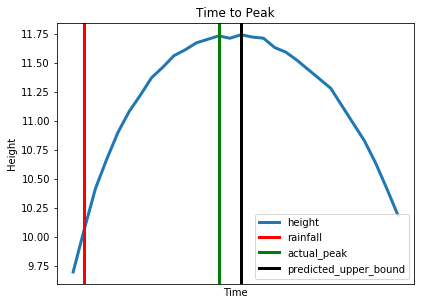

In [46]:
pred:last pltU2`model
pg:raze select site_no,start_time,end_time,peak_time from XtrainPi 
    where unk=`EDT,i in where pred=XtestPi`target,site_no=`02164110,
    target=1,delta_peak>2


rainfall:`x_val`col`title!(pg[`start_time];`r;`rainfall)
actual_peak:`x_val`col`title!(pg[`peak_time];`g;`actual_peak)
pred_bound:`x_val`col`title!(03:30+pg[`start_time];`black;`predicted_upper_bound)

graph:select from str where date within (`date$pg[`start_time];`date$pg[`end_time]), datetime
      within (neg[00:15]+pg[`start_time];[00:10]+pg[`end_time]),(value pg`site_no)=`$site_no

plt[`:plot][graph`datetime;graph`height;`label pykw `height;`linewidth pykw 3];
pltline:{plt[`:axvline][x`x_val;`color pykw x`col;`label pykw x`title;`linewidth pykw 3];}
pltline each (rainfall;actual_peak;pred_bound);

plt[`:legend][`loc pykw `best];
plt[`:title]["Time to Peak"];
plt[`:ylabel]["Height"];
plt[`:xlabel]["Time"];
plt[`:xticks][()];
plt[`:show][];

## Conclusion

From the above results we could predict, with relatively high accuracy, whether an area was likely to flood or not in the next month. We could also produce a model to predict if a stream would reach its peak height within 3.5 hours.

For the monthly models, the future weather predictions played an important role in predicting whether an area would flood or not. Accuracy, recall and precision all increased as the weather predictions and gauged information columns were added to the dataset. This corresponded with the results from the significant feature tests, with lagged_target information and also the windowed rain values of the current month being the most important features to include.

The opposite was true for the time-peak values, as previous rain and stream gauge information along with the basin characteristics were seen to be the most significant features when predicting these values. Including additional information about the future predicted rainfall decreased the accuracy of the results, with the best results being obtained from the model with only past rainfall and basin and soil characteristics being fed into the model.

Both of these results are likely be physically expected. In the case of the monthly prediction, information regarding future forecast was pivotal in whether an area will flood in the next month. Whereas in the case of a time to peak value, it would be unlikely that information about rainfall in the next number of days would add to the predictive power of a model.

Knowing what features contribute to flood susceptibility and the length of time it takes for a river to reach its peak height, is an important piece of information to extract from the model. From this, organizations such as USGS can better prepare for flood events and understand how changing climates and placement of impervious surface can affect the likelihood of flooding.

The best results from the models above were obtained by continuously adjusting the hyper-parameters of the model. The unbalanced target data in the monthly model, meant that weighting the classes was an important feature to experiment with. This was particularly important when trying to obtain high precision and recall results. Between the two models, balance in the recall and precision was better for the XGBoost model.